In [92]:
%load_ext blackcellmagic

In [9]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime

In [6]:
from research.strings import TARGET, PREDICTORS
from research.evaluation import evaluate_model

In [7]:
d_test = pd.read_csv("data/test_data.csv")
y_test = d_test[TARGET]
X_test = d_test[PREDICTORS]
clf = pickle.load(open("models/sklearn-glm.pkl", "rb"))
evaluate_model(y_test, clf.predict(X_test))

F1 Score = 0.08664
Precision = 0.63158
Recall = 0.04651


,Predicted +,Predicted -
Actual +,12,246
Actual -,7,1372


In [216]:
def to_inspection_daynum(date_ser):
    SECONDS = 60 * 60 * 24
    dates = date_ser.apply(lambda d: datetime.fromtimestamp(d * SECONDS))
    daynums = (dates - dates.min()).apply(lambda dt: dt.days + 1).values
    return daynums

In [217]:
def get_days_by_score(days, y_scores):
    res = pd.DataFrame()
    res["Score"] = y_scores
    ranked = res.sort_values(by="Score", ascending=False).reset_index()
    ranked["Day"] = np.sort(days)
    ranked_days = ranked.sort_values(by="index")["Day"].values
    return ranked_days

In [245]:
def get_cumulative(y_true, days):
    res = pd.DataFrame()
    res["Result"] = y_true
    res["Day"] = days
    cumsum = res.groupby("Day")["Result"].sum().cumsum()
    # Assumes that groupby.sum.cumsum is sorted by index
    total = int(cumsum.iloc[-1])
    return cumsum, total

In [219]:
# def get_cumulative_old(ranked):
#     bau_cumsum = ranked.groupby("Day")["Result"].sum().cumsum()
#     dd_cumsum = ranked.groupby("NewDay")["Result"].sum().cumsum()
#     bau_total = int(bau_cumsum.iloc[-1])
#     dd_total = int(dd_cumsum.iloc[-1])
#     assert (
#         dd_total == bau_total
#     ), "Total critical violations found under data-driven model ({}) does not match business-as-usual ({})".format(
#         dd_total, bau_total
#     )
#     return bau_cumsum, dd_cumsum

In [254]:
def plot_cumulative(y_true, days, rankings):
    pal = sns.hls_palette(len(rankings), h=0.5)
    true_total = int(y_true.sum())
    for i, (name, scores) in enumerate(rankings):
        sorted_days = get_days_by_score(days, scores)
        cumsum, total = get_cumulative(y_true, sorted_days)
        assert (
            total == true_total
        ), "Total number of critical violations found in {} ({}) does not match true total ({}).".format(
            name, total, true_total
        )
        sns.lineplot(x=cumsum.index, y=cumsum.values, label=name, color=pal[i])
    plt.xlabel("Inspection Day")
    plt.ylabel("Critical Violations Found")
    plt.title("")
    plt.show()

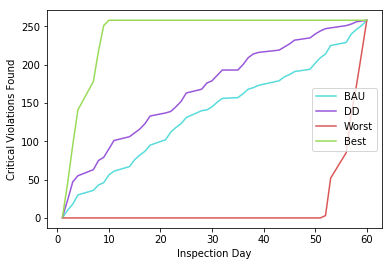

In [256]:
days = to_inspection_daynum(d_test["Inspection_Date"])
usual = 1.0 - (days / days.max())
y_true = y_test.copy()
y_scores = clf.predict_proba(X_test.copy())[:,1]
plot_cumulative(y_true, days, [
    ("BAU", usual),
    ("DD", y_scores),
    ("Worst", 1 - y_true),
    ("Best", y_true)
])

In [273]:
# def show_metrics(y_true, days, y_scores):
sorted_days = get_days_by_score(days, y_scores)
diff = days - sorted_days
res = pd.DataFrame()
res["Result"] = y_true
res["NewDay"] = sorted_days
res["Diff"] = diff
crit_diff = res.query("Result > 0")["Diff"].values
mean_accel = crit_diff.mean()
std_accel = crit_diff.std()


In [283]:
halftime = days.max() / 2
y_half = res.query("NewDay < {}".format(halftime))["Result"].values
y_half.sum() / y_true.sum()

0.68217054263565891

25.155755714153116

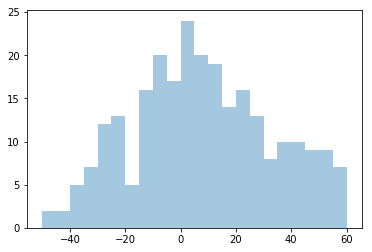

In [270]:
sns.distplot(crit_diff, kde=False, bins=range(-50, 65, 5))